In [1]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/5A 1C/Plataformas de Computación Cognitiva/Trabajo Practico 3/TPs/TP3'

In [4]:
# Load the model
model = load_model(f'{path}/converted_keras_V2/keras_model.h5', compile=False)

# Load the labels
class_names = open(f'{path}/converted_keras_V2/labels.txt', "r").readlines()

In [14]:
# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open(f"{path}/RealWaste/Test/Plastico/Imagen5.jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 0s 126ms/step
Class: Plastico
Confidence Score: 0.99978155


In [25]:
import os
# Prepare to collect predictions
predictions = []

# Loop through each category directory
# Clean up the category names by stripping newline characters and spaces
categories = ['Vidrio', 'Metal', 'Papel', 'Carton','Plastico']

for category in categories:
    category_path = f'{path}/RealWaste/Test/{category}'
    images = os.listdir(category_path)

    if category in ['Vidrio', 'Metal']:
      real_class = 'Vidrio - Metal'
    elif category in ['Papel', 'Carton']:
      real_class = 'Papel - Cartón'
    else:
      real_class = 'Plastico'

    for image_name in images:
        if image_name.endswith('.jpg') | image_name.endswith('.png'):  # Ensure it's an image
            # Open and process the image
            image_path = os.path.join(category_path, image_name)
            image = Image.open(image_path).convert("RGB")
            image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)
            image_array = np.asarray(image)

            # Create batch data
            data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
            # Normalize the image
            normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

            data[0] = normalized_image_array

            # Predict
            prediction = model.predict(data)
            index = np.argmax(prediction)
            class_name = class_names[index]
            confidence_score = prediction[0][index]

            # Store or print predictions
            predictions.append((image_name, real_class, class_name.split(' ', 1)[1].strip(), confidence_score))
            print(f"Image: {image_name}, Real Class: {real_class}, Predicted Class: {class_name}, Confidence: {confidence_score}")


1/1 [==============================] - 0s 145ms/step
Image: Imagen1.png, Real Class: Vidrio - Metal, Predicted Class: 1 Vidrio - Metal
, Confidence: 0.9986469149589539
1/1 [==============================] - 0s 104ms/step
Image: Imagen2.png, Real Class: Vidrio - Metal, Predicted Class: 2 Plastico
, Confidence: 0.9807299375534058
1/1 [==============================] - 0s 86ms/step
Image: Imagen3.png, Real Class: Vidrio - Metal, Predicted Class: 1 Vidrio - Metal
, Confidence: 0.9466199278831482
1/1 [==============================] - 0s 115ms/step
Image: Imagen4.png, Real Class: Vidrio - Metal, Predicted Class: 1 Vidrio - Metal
, Confidence: 0.9341294765472412
1/1 [==============================] - 0s 96ms/step
Image: Imagen5.png, Real Class: Vidrio - Metal, Predicted Class: 0 Papel - Cartón
, Confidence: 0.9999698400497437
1/1 [==============================] - 0s 60ms/step
Image: Imagen1.jpg, Real Class: Vidrio - Metal, Predicted Class: 1 Vidrio - Metal
, Confidence: 0.9990177154541016
1

In [26]:
import pandas as pd
df = pd.DataFrame(predictions)
df.columns = ['Image Name', 'Real Class', 'Predicted Class', 'Confidence Score']

In [27]:
df.head()

,Image Name,Real Class,Predicted Class,Confidence Score
0,Imagen1.png,Vidrio - Metal,Vidrio - Metal,0.998647
1,Imagen2.png,Vidrio - Metal,Plastico,0.980730
2,Imagen3.png,Vidrio - Metal,Vidrio - Metal,0.946620
3,Imagen4.png,Vidrio - Metal,Vidrio - Metal,0.934129
4,Imagen5.png,Vidrio - Metal,Papel - Cartón,0.999970


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels = df['Real Class']
predictions = df['Predicted Class']
model_name = "TeachableMachine"

report = classification_report(true_labels, predictions, output_dict=True)
conf_matrix = confusion_matrix(true_labels, predictions, labels=['Papel - Cartón', 'Vidrio - Metal', 'Plastico'])

# Calcular especificidad: TN / (TN + FP)
# Para un problema de multi-clase, calculamos la especificidad para cada clase y luego promediamos.
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)

avg_specificity = sum(specificity) / len(specificity)

# Crear un DataFrame para guardar los resultados
results = pd.DataFrame()

# Guardar métricas en el DataFrame
results.loc[model_name, 'Accuracy'] = report['accuracy']
results.loc[model_name, 'Precision'] = report['weighted avg']['precision']
results.loc[model_name, 'Recall'] = report['weighted avg']['recall']
results.loc[model_name, 'F1-Score'] = report['weighted avg']['f1-score']
results.loc[model_name, 'Specificity'] = avg_specificity

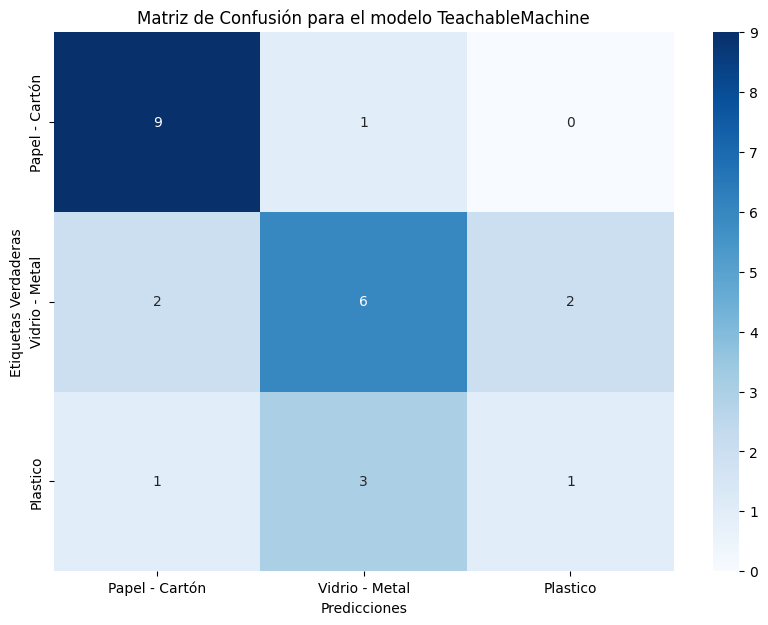

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions, labels=['Papel - Cartón', 'Vidrio - Metal', 'Plastico'])

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Papel - Cartón', 'Vidrio - Metal', 'Plastico'],
            yticklabels=['Papel - Cartón', 'Vidrio - Metal', 'Plastico'])
plt.title(f'Matriz de Confusión para el modelo {model_name}')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

In [30]:
results.head()

,Accuracy,Precision,Recall,F1-Score,Specificity
TeachableMachine,0.64,0.606667,0.64,0.617273,0.811111


In [32]:
report

{'Papel - Cartón': {'precision': 0.75,
  'recall': 0.9,
  'f1-score': 0.8181818181818182,
  'support': 10},
 'Plastico': {'precision': 0.3333333333333333,
  'recall': 0.2,
  'f1-score': 0.25,
  'support': 5},
 'Vidrio - Metal': {'precision': 0.6,
  'recall': 0.6,
  'f1-score': 0.6,
  'support': 10},
 'accuracy': 0.64,
 'macro avg': {'precision': 0.561111111111111,
  'recall': 0.5666666666666668,
  'f1-score': 0.5560606060606061,
  'support': 25},
 'weighted avg': {'precision': 0.6066666666666667,
  'recall': 0.64,
  'f1-score': 0.6172727272727273,
  'support': 25}}